In [1]:
### Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as c
import os, sys
from astropy.table import Table, vstack
from astropy import units as u
from astropy.io import ascii
from astropy.time import Time
from scipy.optimize import curve_fit
from scipy import constants as c
from scipy.special import j1

### Get some information from the three vlbi surveys with b-smbh candidates

**GOODS-N** 
* central rms 9 uJy/beam
* \#sources targeted ~ 340 sources
* Contigious $7.5^2\cdot\pi$ arcmin squared. 
* Five separate pointings.
* One candidate bsmbh.

**COSMOS-VLBA**
* central rms ~10 uJy/beam
* \#sources targeted ~ 2865
* 4 deg squared area.
* Made of 23 pointings.
* 2 candidate bsmbhs

**SPARCS-N**
* central rms ~ 6 uJy/beam
* \# sources targeted ~ 52
* $0.5^2\cdot\pi$ area 
* One pointing
* One B-SMBH candidate

### SWEEPs estimates per year

In [2]:
if os.path.exists('evn_obs.ecsv') == False:
    import pyvo as vo
    service = vo.dal.TAPService("https://evn-vo.jive.eu/tap")
    x = np.linspace(-90,90,361)
    for i in range(360):
        if i%10 == 0:
            print(x[i])
        resultset = service.search("""SELECT *
                                    FROM evn.main WHERE s_dec BETWEEN %d AND %d"""%(x[i],x[i+1]))
        
        if i == 0:
            at = resultset.to_table()
        else:
            at = vstack([at, resultset.to_table()])
    at.write('evn_obs.ecsv', overwrite=True)
at = ascii.read('evn_obs.ecsv')

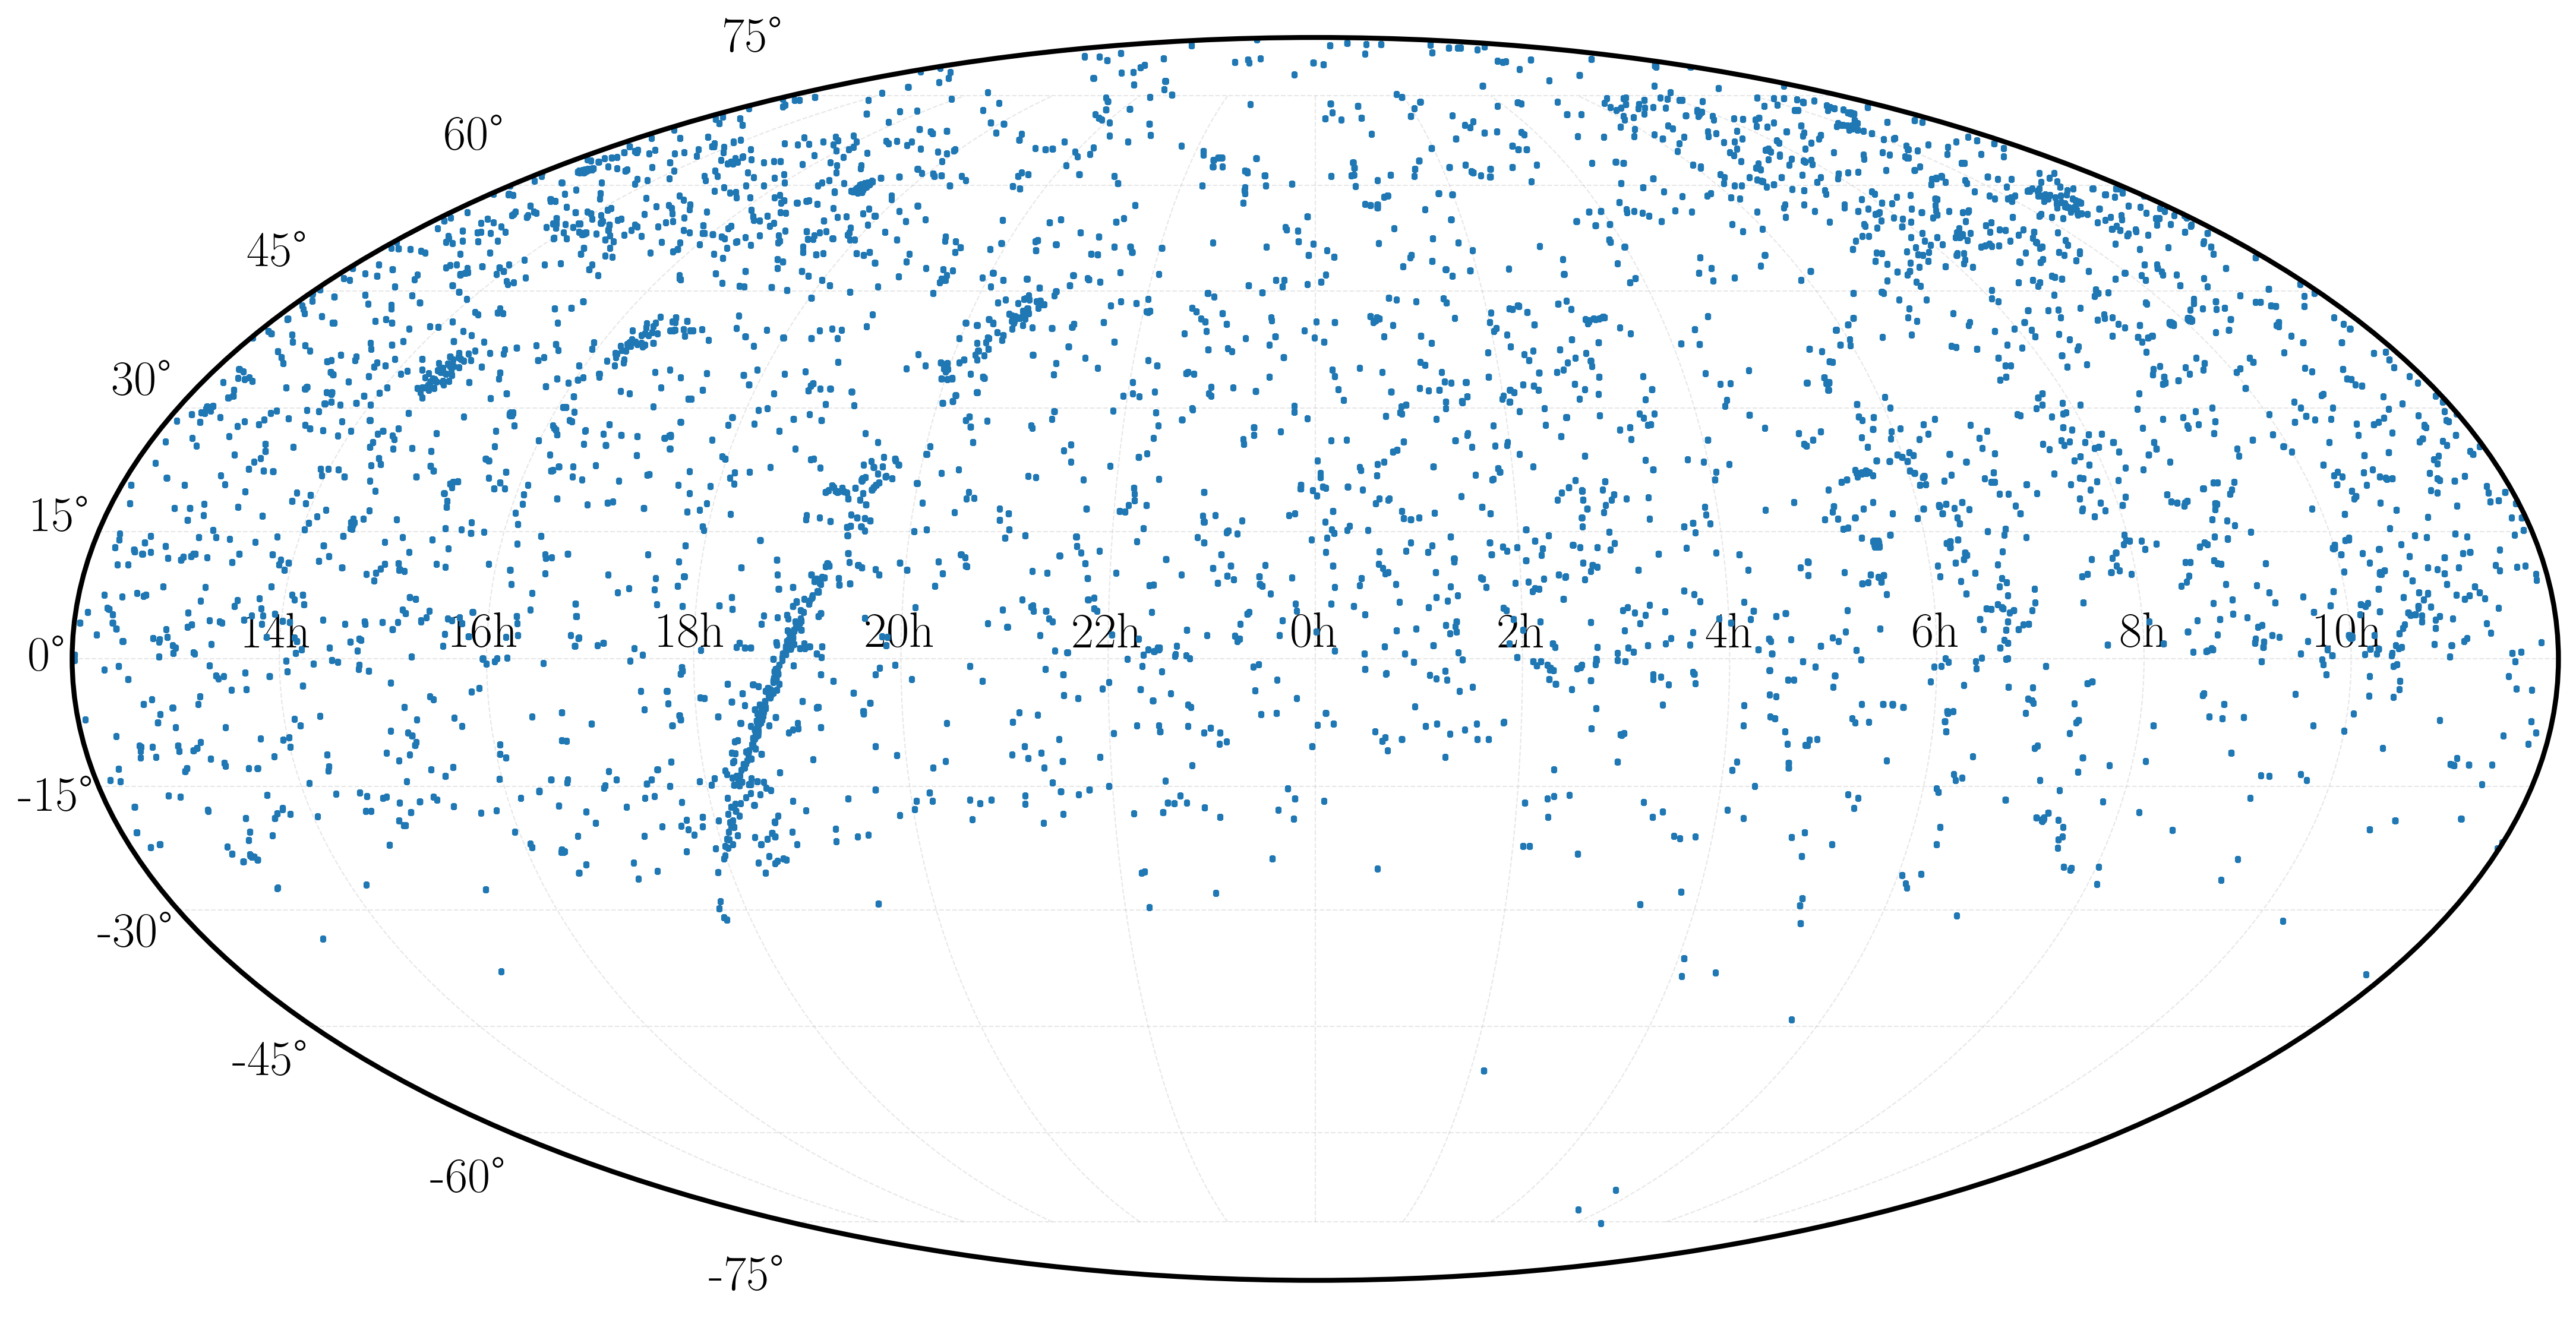

In [3]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter((at['s_ra']).to(u.radian), (at['s_dec']).to(u.radian),s=1.5)
#ax.scatter(ra, (evn_obs[1]*u.deg).to(u.radian),s=0.1)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
plt.show()

In [4]:
t = Time(at['t_max'],format='mjd')

In [5]:
yr_iso = np.arange(1998,2026,1)
yr = Time(np.char.add(np.arange(1998,2026,1).astype('str'),'-01-01T00:00:00.000')).mjd

In [6]:
n_exp = []
n_epo = []
L_exp = []
L_t = []
for i in range(len(yr)-1):
    n_epo.append(len(at['t_min'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])]))
    n_exp.append(len(np.unique(at['obs_id'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])])))
    L_exp.append(len(np.unique(at['obs_id'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])&\
                                           (at['em_min']>0.15)&(at['em_max']<0.25)])))
    t_min = np.unique(at['t_min','t_max'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])&\
                            (at['em_min']>0.15)&(at['em_max']<0.25)])['t_min']
    t_max = np.unique(at['t_min','t_max'][(at['t_min']>yr[i])&(at['t_min']<yr[i+1])&\
                            (at['em_min']>0.15)&(at['em_max']<0.25)])['t_max']
    L_t.append(np.sum(t_max-t_min))

<>:6: SyntaxWarning: invalid escape sequence '\#'
<>:6: SyntaxWarning: invalid escape sequence '\#'
/var/folders/0f/ksrbwvrs3fb4zx5hqxpm3hnr0000gq/T/ipykernel_63880/2063802750.py:6: SyntaxWarning: invalid escape sequence '\#'
  ax.set_ylabel('\# experiments per year')


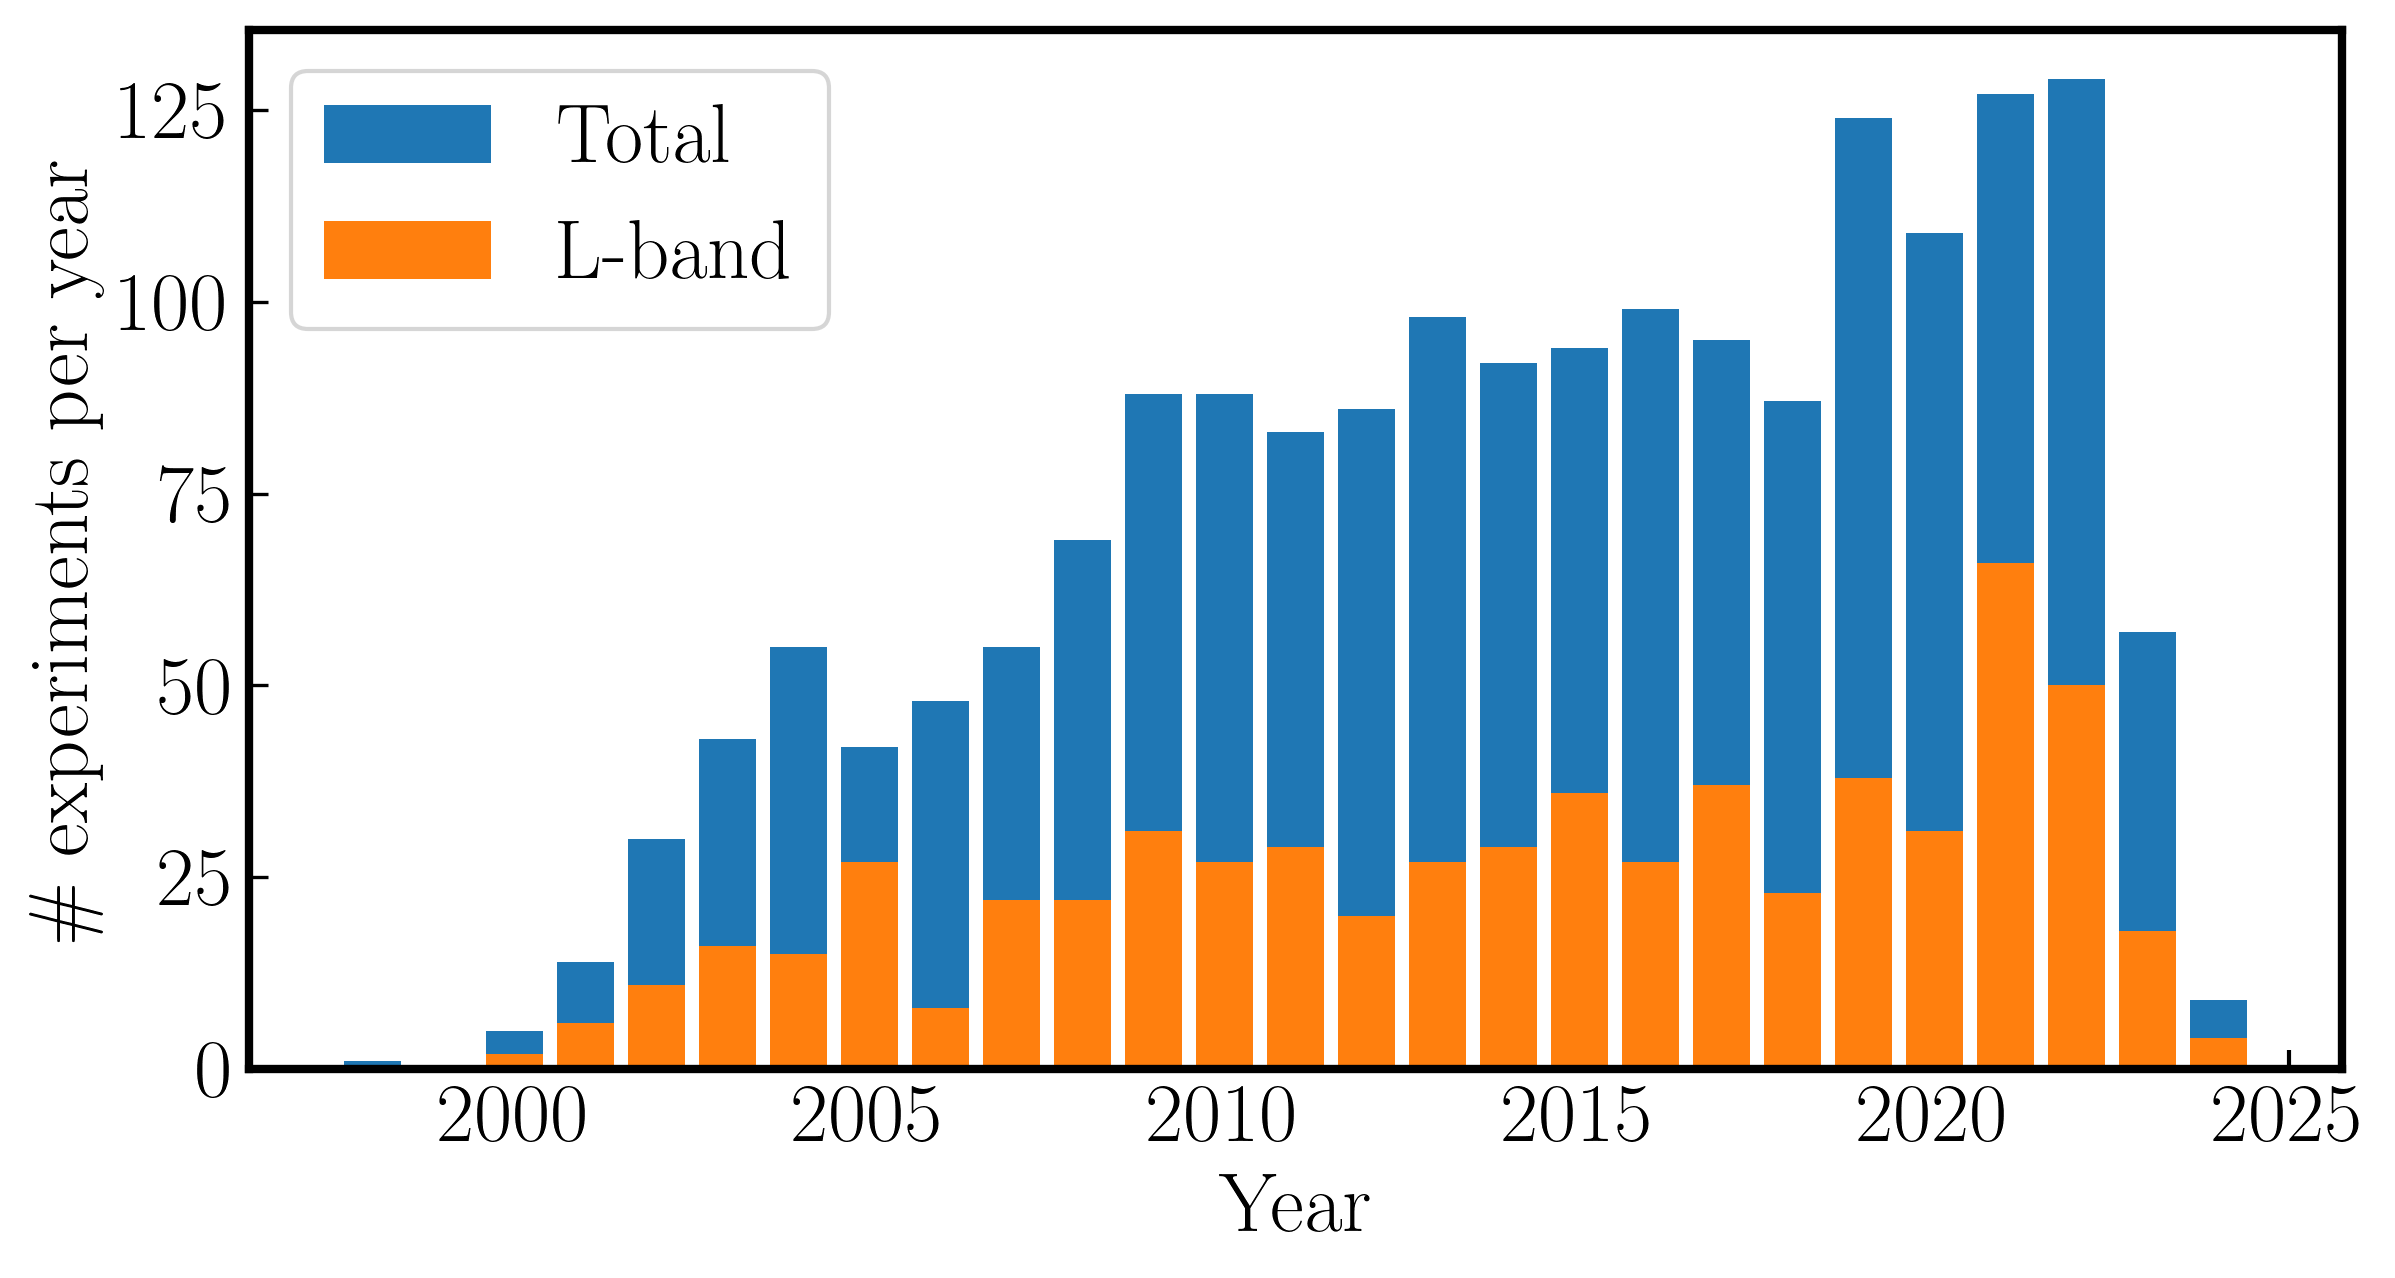

In [7]:
fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(111)
ax.bar(yr_iso[:-1],n_exp,label='Total')
ax.bar(yr_iso[:-1],L_exp,label='L-band')
ax.set_xlabel('Year')
ax.set_ylabel('\# experiments per year')
ax.legend()
fig.savefig('exp_per_year.pdf')
ax.grid(False)
plt.show()

### Use single year of data that is broadly representative of an EVN year

Take 2021

In [8]:
## sort out the unique times to remove the multi phase centre entries
yr_small = Time(['2021-01-01T00:00:00.000','2022-01-01T00:00:00.000']).mjd
at_21 = at[(at['t_min']>yr_small[0])&(at['t_min']<yr_small[1])]
at_temp, ar = np.unique(at_21['t_min','t_max'],return_index=True)
at_temp=at_21[ar]
at_temp_L = at_temp[(at_temp['em_min']>0.15)&(at_temp['em_max']<0.25)]
del ar, at_21

#### Some yearly stats for the paper

In [9]:
exp_names = np.unique(at_temp['obs_id'])
total_time = np.sum(at_temp['t_xel']*at_temp['t_resolution'])*u.s
total_time_L = np.sum(at_temp_L['t_xel']*at_temp_L['t_resolution'])*u.s

In [10]:
print('Total time in 2021')
total_time.to(u.day)

Total time in 2021


<Quantity 43.34206019 d>

In [11]:
print('Total time at L band (18/21 cm) in 2021')
total_time_L.to(u.day)

Total time at L band (18/21 cm) in 2021


<Quantity 25.09377315 d>

In [12]:
total_time_L/total_time

<Quantity 0.57897047>

#### Have some model for the sensitivity

The example array used will be an EVN+e-MERLIN array using the following - 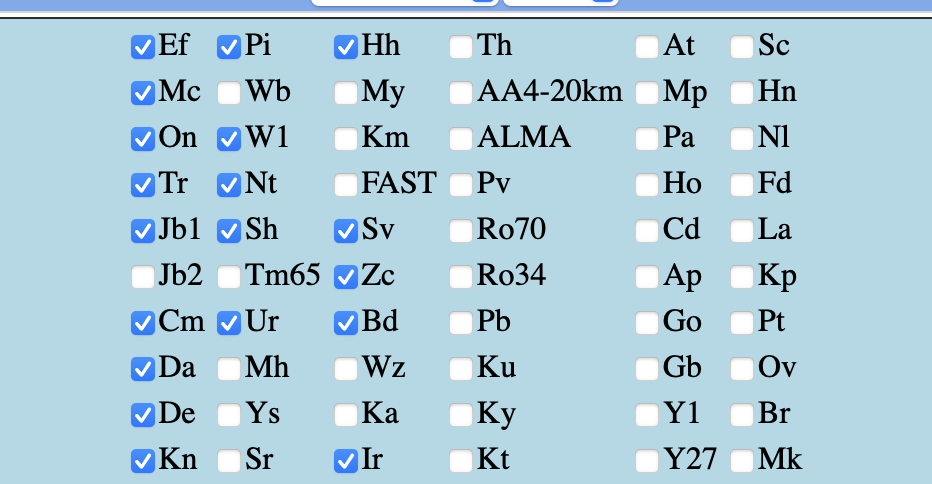

This gives a sensitivity of 9.98 uJy/beam for 100 mins / 6000 seconds at 1gbps data rate on source

Then, we can use the standard radiometer equation to set the model. Sensitivity will scale as the square root of the time on the source

$$ \sigma~\mathrm{[\mu Jy\,beam^{-1}]} \approx 10.10\left(\frac{100}{t~\mathrm{[min]}}\right)^{1/2}$$

In [13]:
t_L = (at_temp_L['t_xel']*at_temp_L['t_resolution'])/60
at_temp_L['sens'] = 10.10*((100/t_L)**0.5)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/var/folders/0f/ksrbwvrs3fb4zx5hqxpm3hnr0000gq/T/ipykernel_63880/3977262622.py:6: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('Estimated $1\sigma$ sensitivity ($\mathrm{\mu Jy\,beam^{-1}})$')


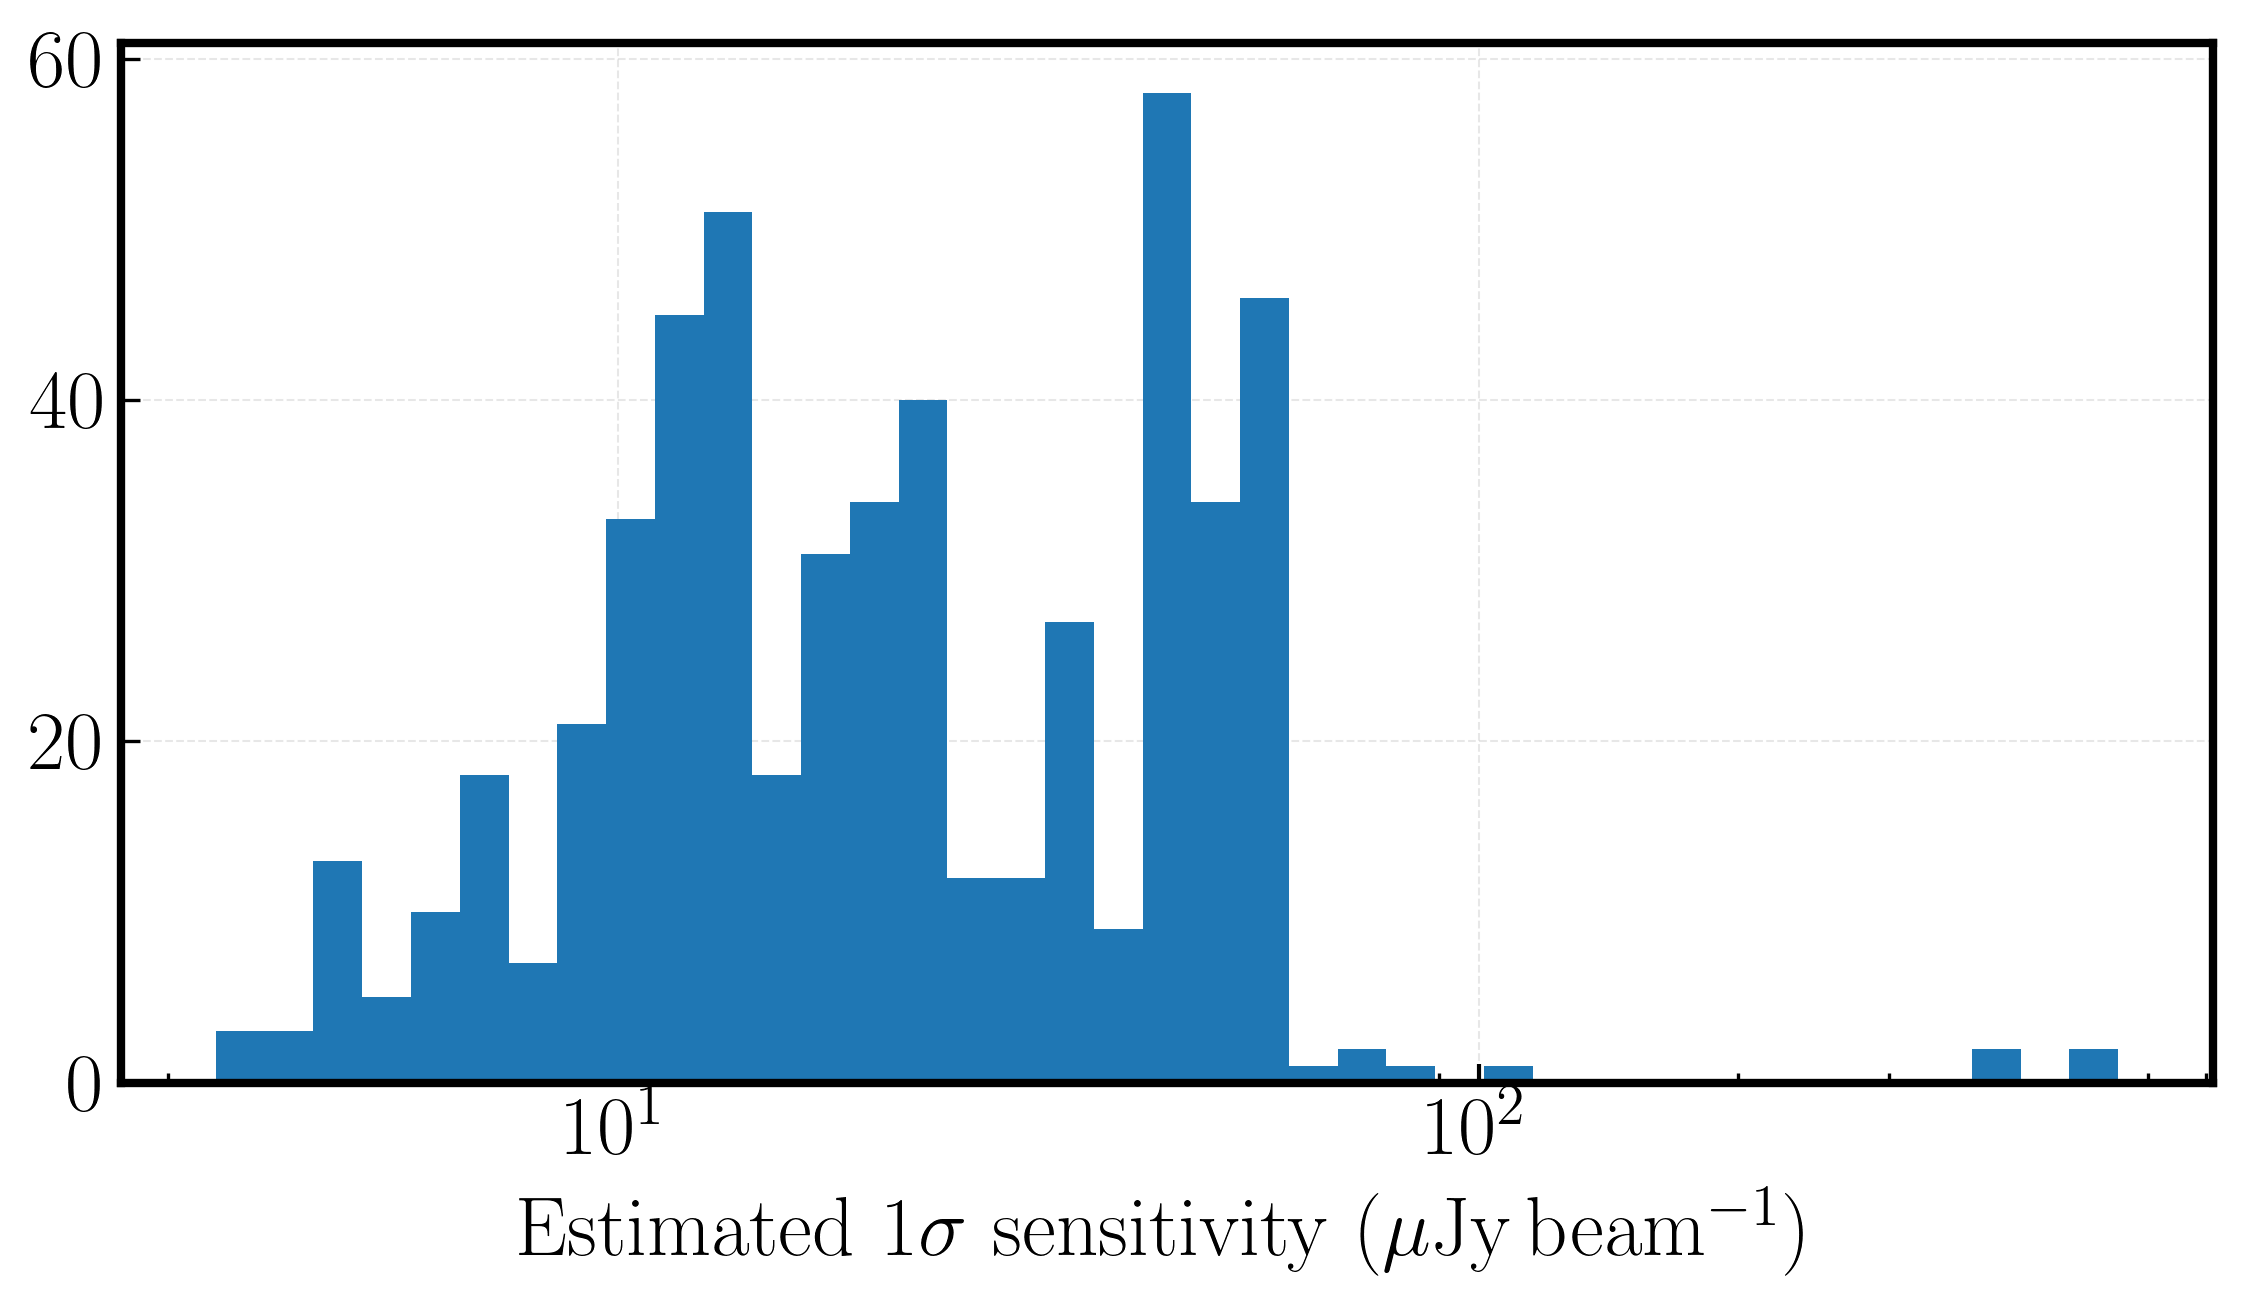

In [14]:
fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(111)
logbins = np.logspace(np.log10(np.min(at_temp_L['sens'])),np.log10(np.max(at_temp_L['sens'])),40)
ax.hist(at_temp_L['sens'],bins=logbins)
ax.set_xscale('log')
ax.set_xlabel('Estimated $1\sigma$ sensitivity ($\mathrm{\mu Jy\,beam^{-1}})$')
fig.savefig('sensitivity_EVN2021.png')
plt.show()

In [15]:
print(np.median(at_temp_L['sens'].value),np.mean(at_temp_L['sens'].value))

19.437459062717398 28.845696788944117


#### Areal density measurements

In [16]:
import numpy
from scipy.special import bdtri, ndtr, pdtri
from sys import exit

def poissonLimits(k, cl=None, sigma=False):
    """
 NAME:
       poissonLimits
 AUTHOR:
       Tim Haines, thaines.astro@gmail.com
 PURPOSE:
       This function computes the single-sided upper and lower
       confidence limits for the Poisson distribution.
 CATEGORY:
       Statistics and probability
 CALLING SEQUENCE:
       (u,l) = poissonLimits(k, [cl [, sigma]])
 INPUTS:
       k:      A strictly nonnegative integer that specifies the
               number of observed events. Can be a list or numpy array.
        
 OPTIONAL INPUTS:
       cl:     The confidence level in the interval [0, 1). The default
               is 0.8413 (i.e., 1 sigma)
 OPTIONS:
       sigma:  If this is true, then cl is assumed to be a
               multiple of sigma, and the actual confidence level
               is computed from the standard normal distribution with
               parameter cl.
 RETURNS:
        Two lists: the first containing the upper limits, and the second
        containing the lower limits. If the input is a numpy array, then
        numpy arrays are returned instead of lists. If the input is a scalar,
        then scalars are returned.
 REFERENCES:
       N. Gehrels. Confidence limits for small numbers of events in astrophysical
       data. The Astrophysical Journal, 303:336-346, April 1986.
 EXAMPLE:
       Compute the confidence limits of seeing 20 events in 8
       seconds at the 2.5 sigma.
           (u,l) = poissonLimits(20, 2.5, sigma=True)
               u = 34.1875
               l = 10.5711
       However, recall that the Poisson parameter is defined as the
       average rate, so it is necessary to divide these values by
       the time (or space) interval over which they were observed.
       Since these are the confidence limits, the fraction would be
       reported as
           2.5 (+4.273, -1.321) observations per second
"""
    if cl is None:
        cl = 1.0
        sigma = True
    
    if sigma:
        cl = ndtr(cl)

    # Since there isn't any syntactical advantage to using
    # numpy, just convert it to a list and carry on.
    isNumpy = False
    if isinstance(k,numpy.ndarray):
        k = k.tolist()
        isNumpy = True
        
    # Box single values into a list
    isScalar = False
    if not isinstance(k,list):
        k = [k]
        isScalar = True
    
    upper = []
    lower = []
    
    for x in k:
        upper.append(pdtri(x,1-cl))
        
        # See Gehrels (1986) for details
        if x == 0:
            lower.append(0.0)
        else:
            lower.append(pdtri(x-1,cl))
    
    if isNumpy:
        upper = numpy.array(upper)
        lower = numpy.array(lower)
    
    # Scalar-in/scalar-out
    if isScalar:
        return (upper[0], lower[0])
    
    return np.array(upper),np.array(lower)

In [17]:
def calculate_areal_density(Nvar,Nepochs,rMAX,rHP,Sdet,Spc,cl):
    if Nvar == 0:
        print('Can only give upper limits, the rest will be nans')
        N_high,N_low = poissonLimits(k=Nvar,cl=cl)
        N_var = np.array([np.nan,N_high,np.nan])
    else:
        N_high,N_low = poissonLimits(k=Nvar,cl=cl)
        N_var = np.array([Nvar,N_high,N_low])
        
    pre = (3.*N_var*np.log(2.))/(2.*np.pi*(rHP**2.))
    fluxes = (Spc/Sdet)**(1.5)
    post = 1./(1 - (np.e**(-3*(rMAX**2)*np.log(2)/(2*(rHP**2)))))
    return pre*fluxes*post,pre*fluxes*post/Nepochs


In [18]:
calculate_areal_density(1,1,0.233,0.258,30.45,30.45,0.95)

(array([ 8.6964335 , 41.25470232,  0.44606872]),
 array([ 8.6964335 , 41.25470232,  0.44606872]))

## other VLBI surveys

EVN primary beams

In [19]:
ang,pb = np.load('evn_array.npy')
def gaussian_func(x,  sigma):
    return np.exp(-(x)**2/(2*sigma**2)) 
def Bessel_pb(x, D):
	x = (x/60.)*(np.pi/180.)
	wl = c.c/1.6e9
	insert = ((D*np.pi)/wl)*np.sin(x)
	return ((2*j1(insert))/insert)**2
def Bessel_pb2(D,wl,sep):
	insert = ((D*np.pi)/wl)*np.sin(sep)
	I = ((2*j1(insert))/insert)**2
	if sep == 0:
		return 1
	else:
		return I

initial_guess = [5.5]
popt_g, pcov_g = curve_fit(gaussian_func, ang[:43], pb[:43],p0=initial_guess)
initial_guess = [43]
popt_b, pcov_b = curve_fit(Bessel_pb, ang[1:], pb[1:],p0=initial_guess)
print(np.sqrt(np.diag(pcov_g)))
popt_g

[0.00816053]


array([4.73102885])

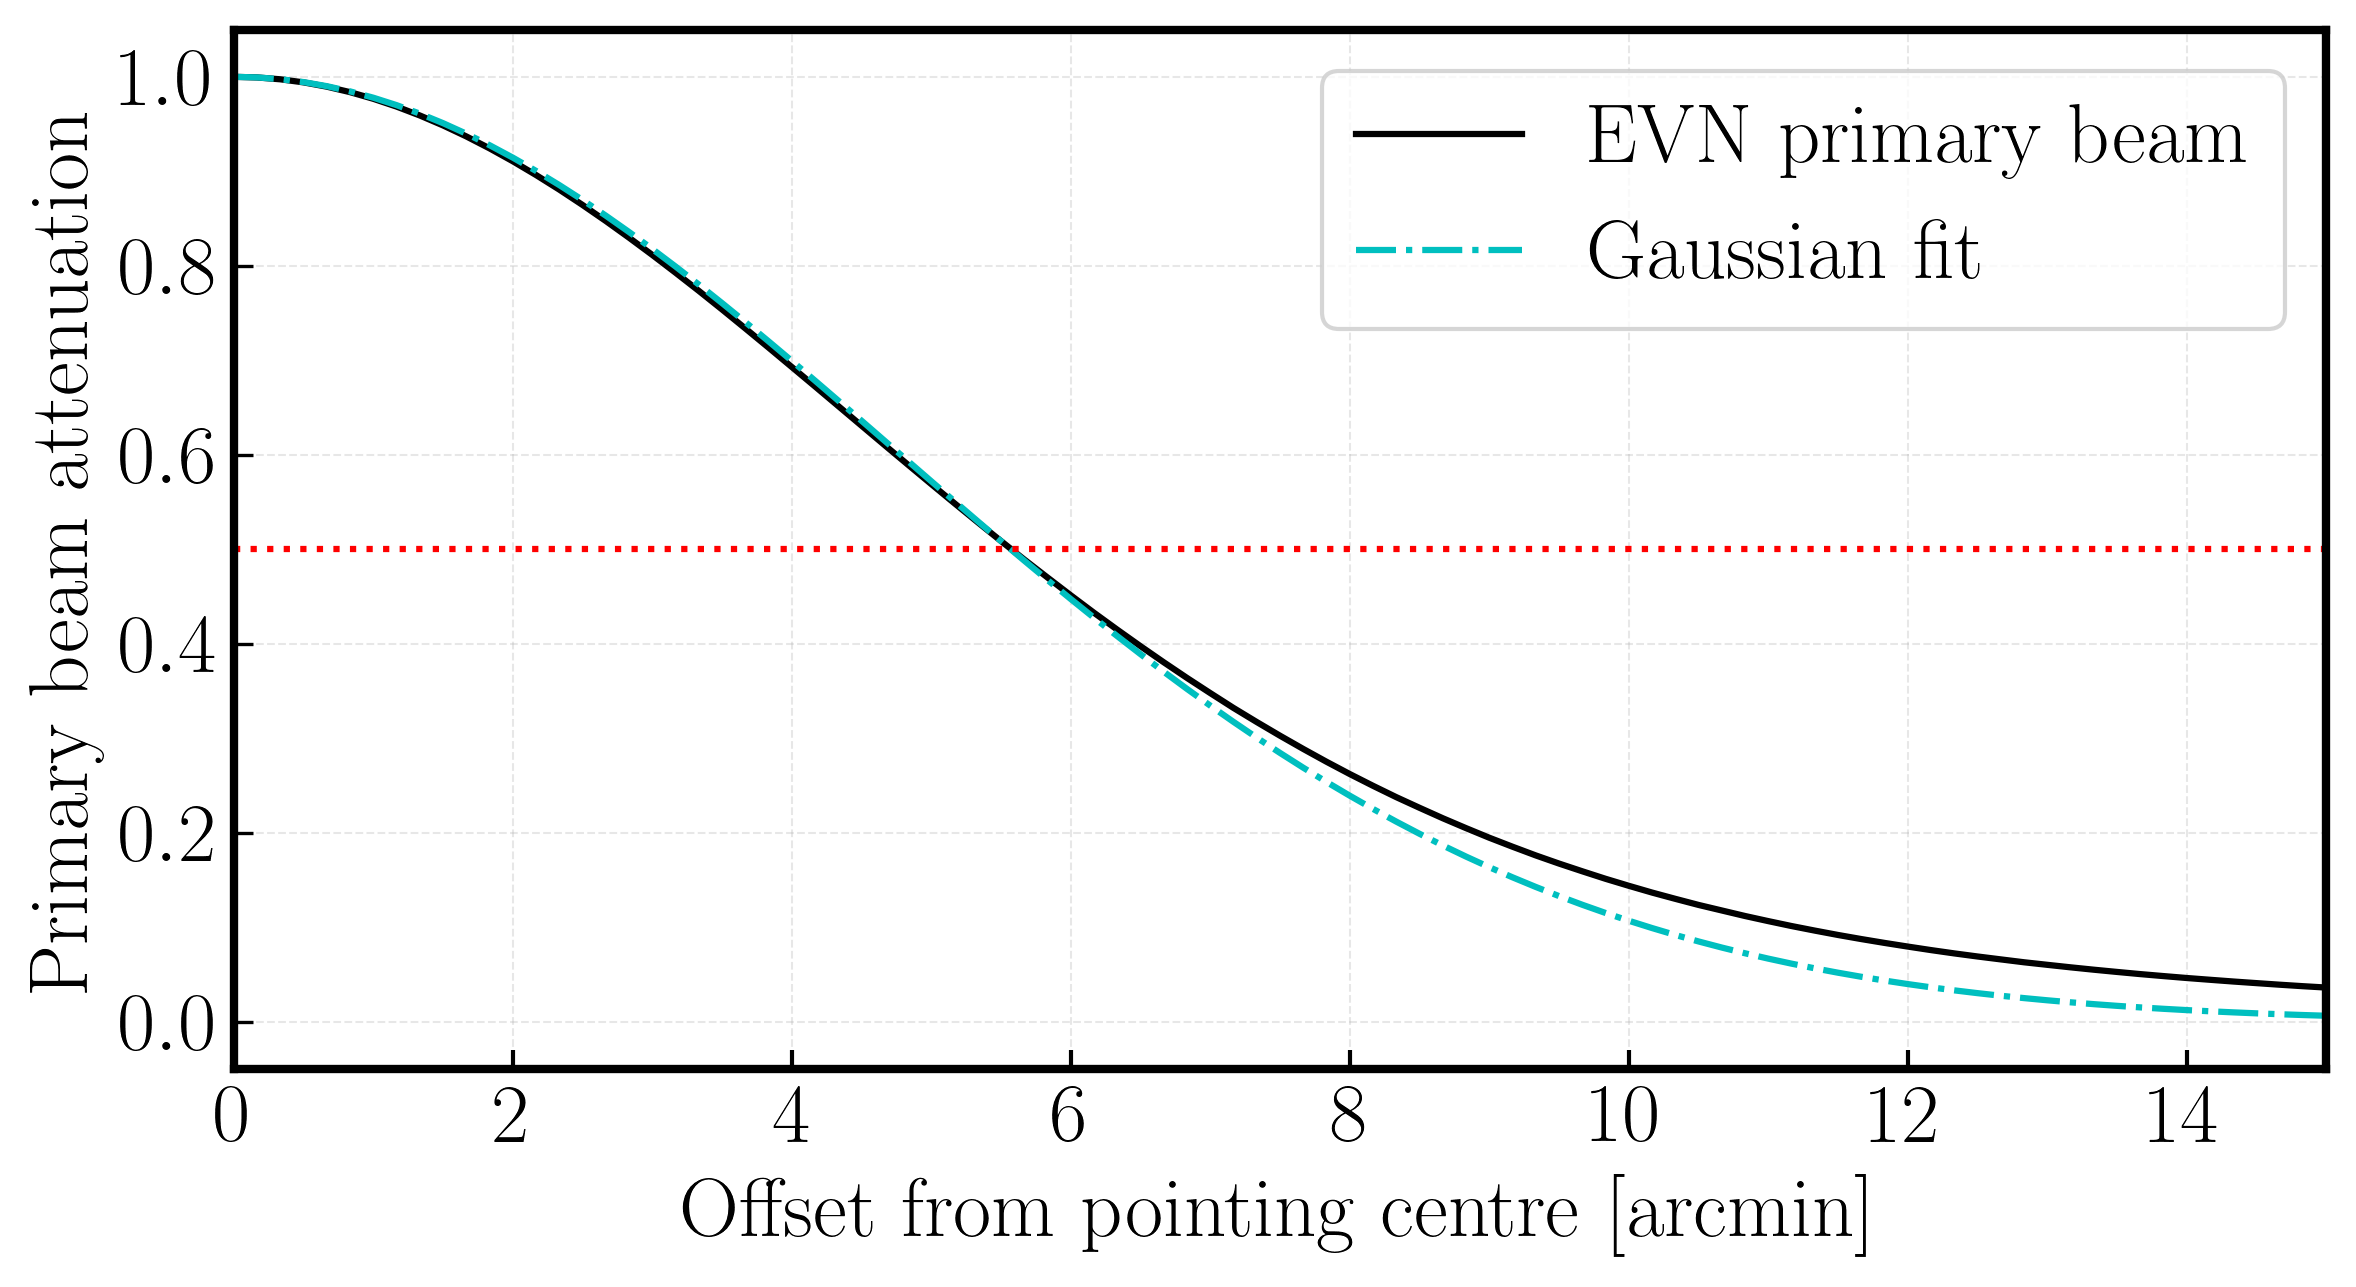

In [20]:
fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(111)
ax.plot(ang,pb,'k-',label='EVN primary beam')
ax.plot(ang,gaussian_func(ang,*popt_g),'c-.',label='Gaussian fit')
#ax.plot(ang,Bessel_pb(ang,*popt_b))
ax.axhline(0.5,c='r',ls=':')
ax.set_xlim(0,15)
ax.set_ylabel('Primary beam attenuation')
ax.set_xlabel('Offset from pointing centre [arcmin]')
ax.legend()
fig.savefig('EVN_pb_atten.png')
plt.show()

In [21]:
FWHM = 2*np.sqrt(2*np.log(2))*popt_g
print(np.round(FWHM[0],2),'arcmin')

11.14 arcmin


In [22]:
def offset_sens(sigma,t):
    b = 4.74
    s = 101
    a = 2*(b**2)
    c = (sigma*(np.sqrt(t)))/(s)
    return np.sqrt(a*np.log(c))

def inv_offset_sens(offset,t):
    b = 4.74
    return 10.10*np.sqrt(100/t)*(np.e**(1*((offset**2)/(2*(b**2)))))

def offset_area_sens(sigma,t):
    b = 4.74
    s = 101
    a = 2*np.pi*(b**2)
    c = (sigma*(np.sqrt(t)))/(s)
    val = np.sqrt(a*np.log(c))**2
    return np.nan_to_num(val,nan=0)/(60**2)

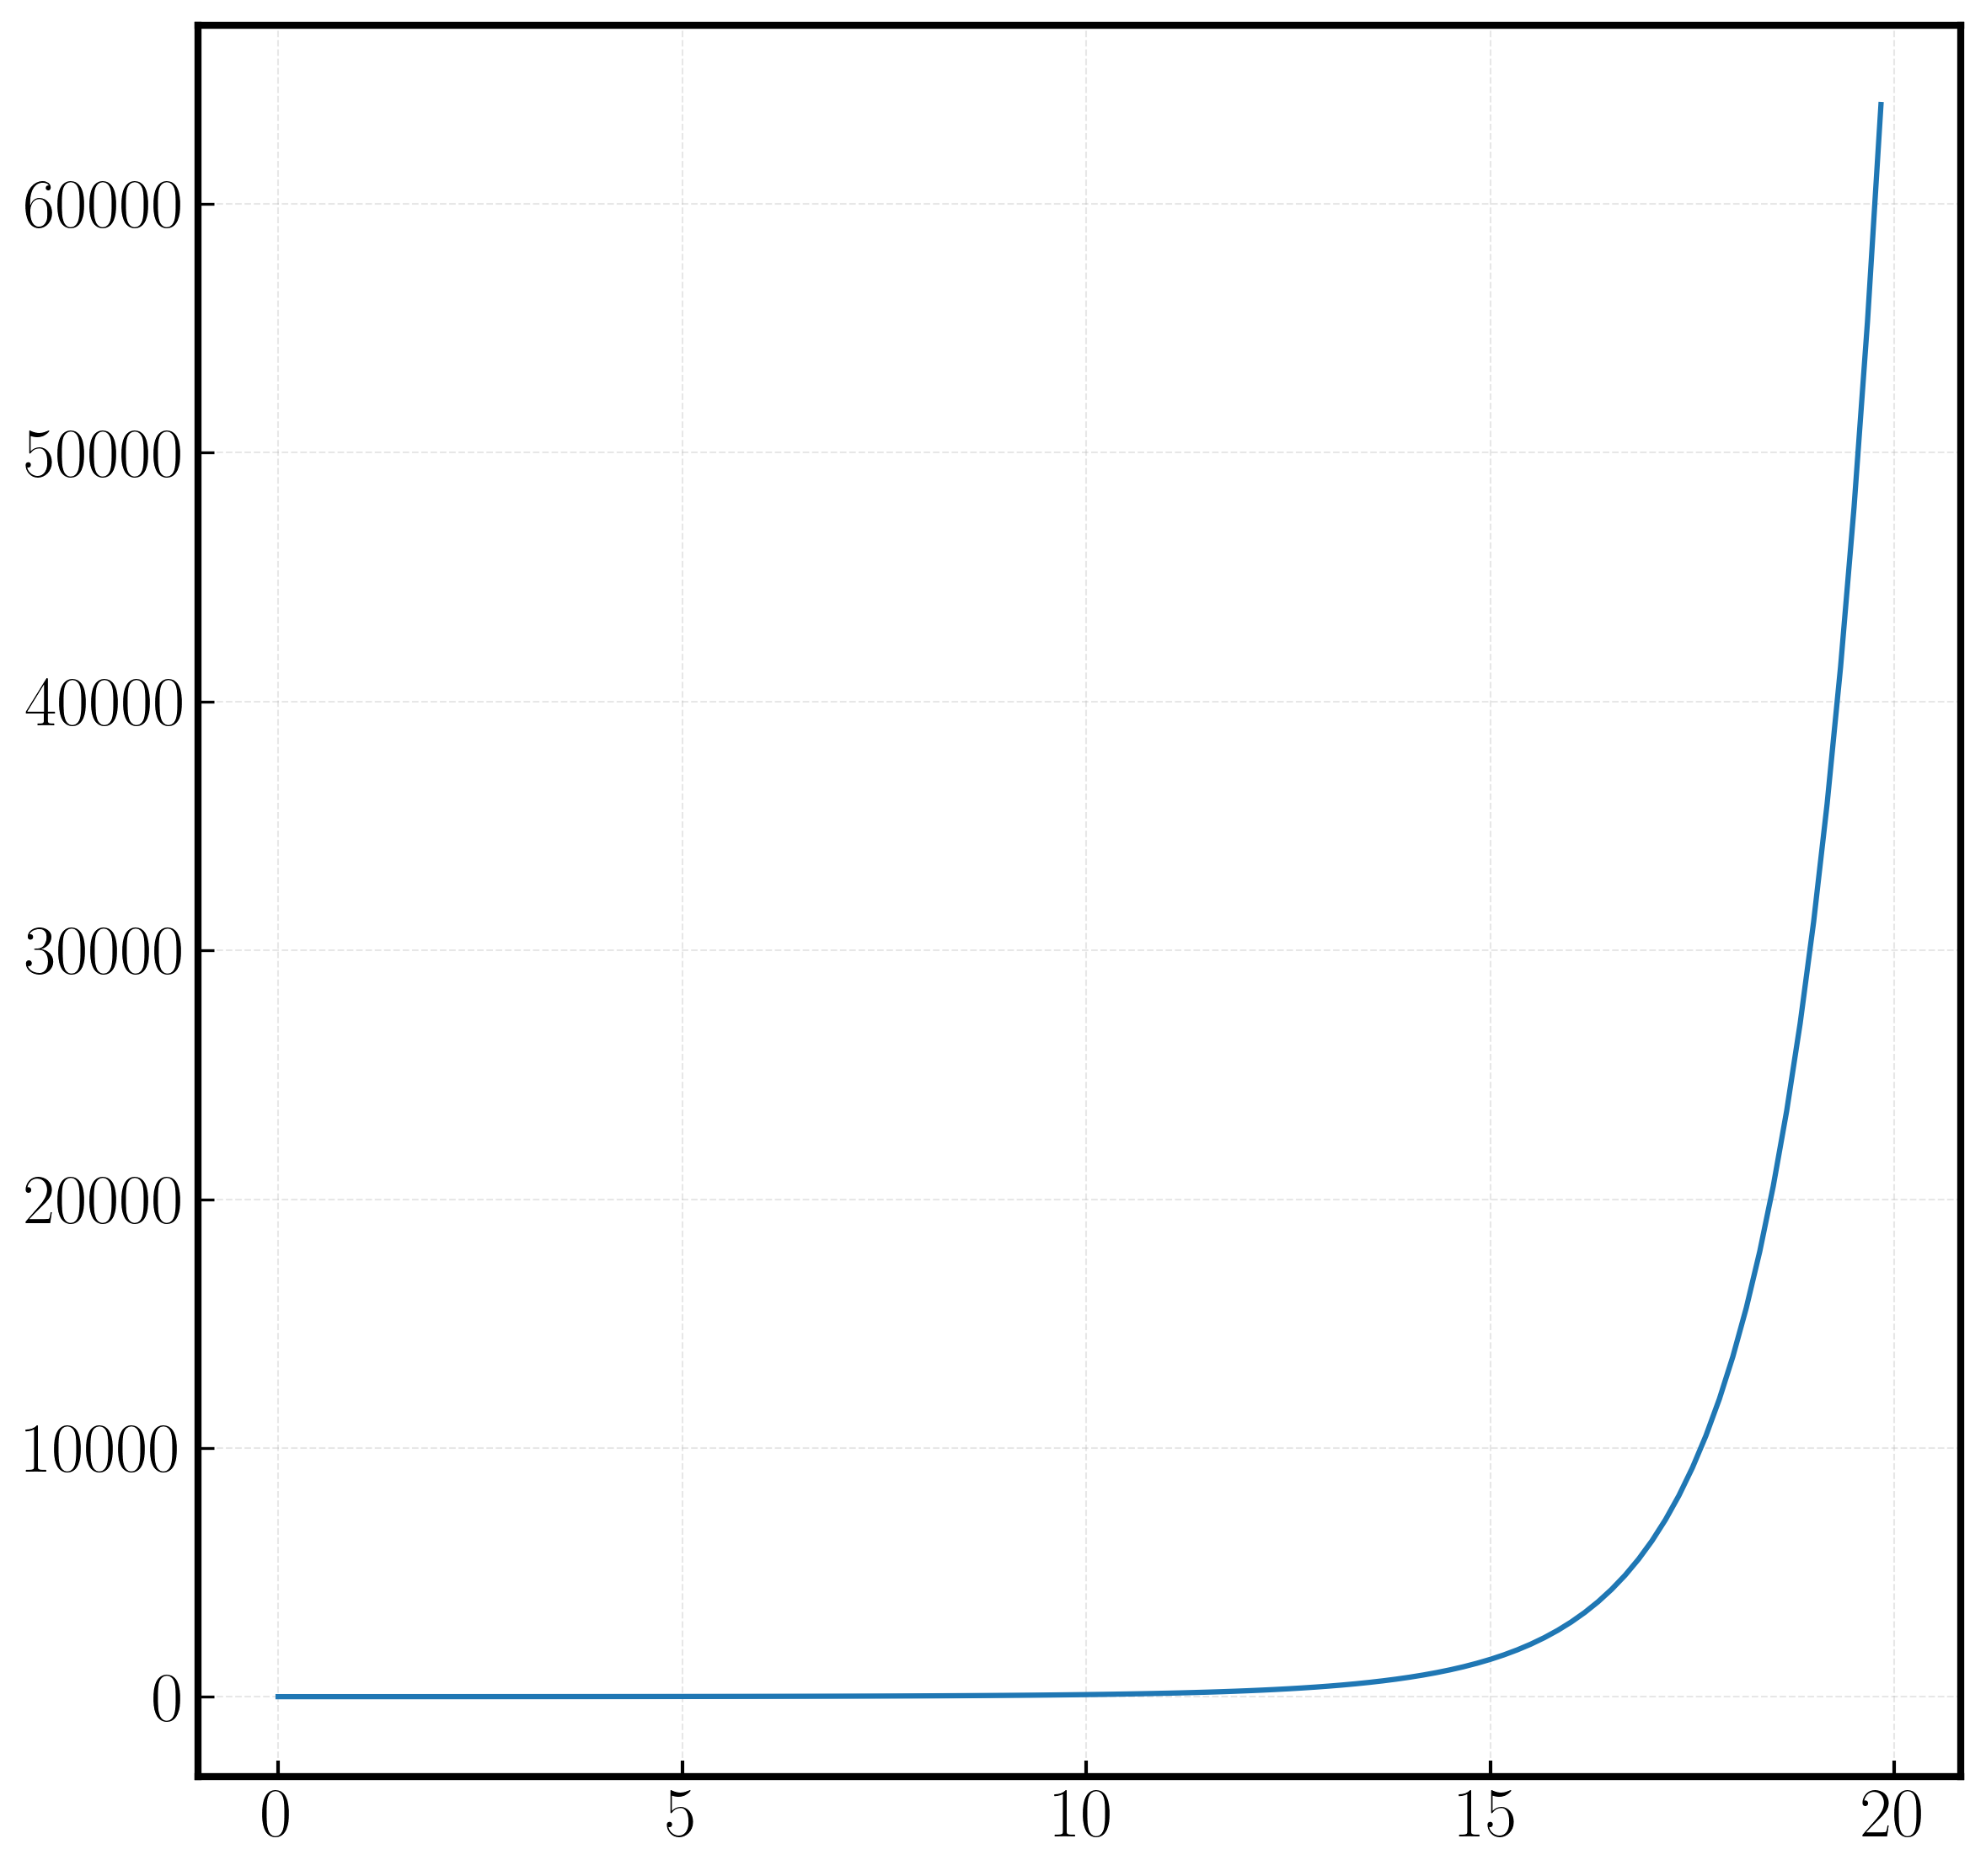

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ang,inv_offset_sens(ang,100))

In [30]:
sigma = np.linspace(0,2000,5000)

area = []
for i in range(len(sigma)):
    area.append(np.sum(offset_area_sens(sigma[i],t_L)))
area = np.array(area)


/var/folders/0f/ksrbwvrs3fb4zx5hqxpm3hnr0000gq/T/ipykernel_63880/4205219742.py:17: RuntimeWarning: divide by zero encountered in log
  val = np.sqrt(a*np.log(c))**2
/var/folders/0f/ksrbwvrs3fb4zx5hqxpm3hnr0000gq/T/ipykernel_63880/4205219742.py:17: RuntimeWarning: invalid value encountered in sqrt
  val = np.sqrt(a*np.log(c))**2


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/var/folders/0f/ksrbwvrs3fb4zx5hqxpm3hnr0000gq/T/ipykernel_63880/1568685555.py:4: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('$\sigma < \sigma_\mathrm{rms}$ [$\mu\mathrm{Jy\,beam^{-1}}$]')


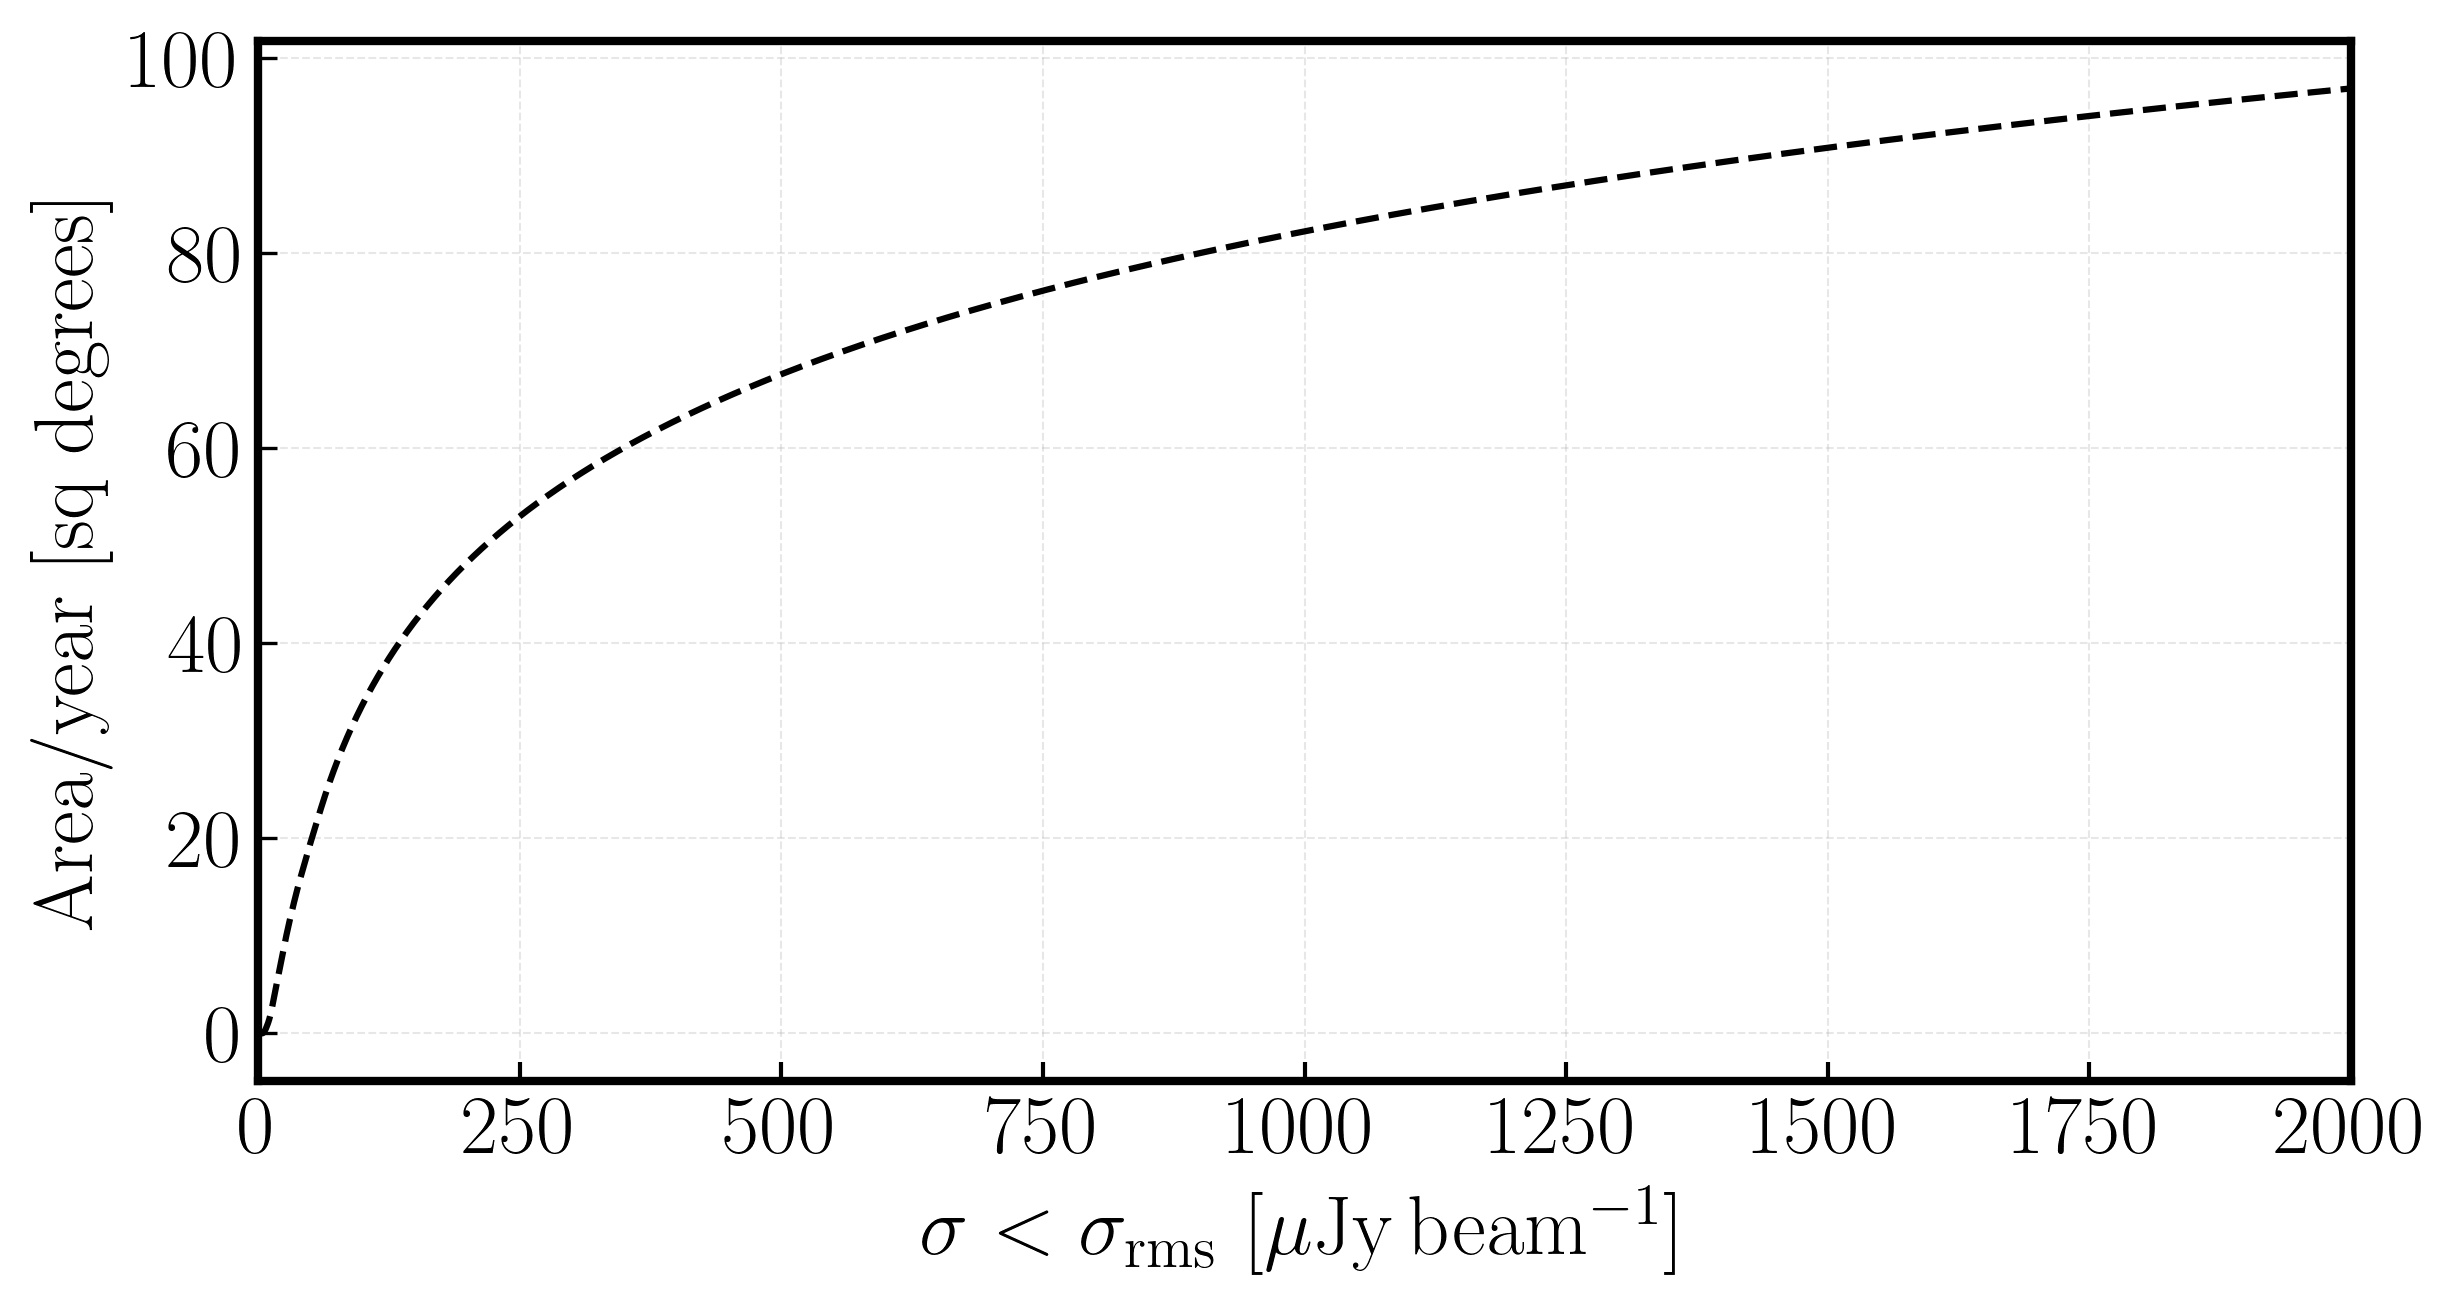

In [32]:
fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(111)
ax.plot(sigma,area,'k--')
ax.set_xlabel('$\sigma < \sigma_\mathrm{rms}$ [$\mu\mathrm{Jy\,beam^{-1}}$]')
ax.set_ylabel('Area/year [sq degrees]')
ax.set_xlim(0,2000)
fig.savefig('sweeps_area.png')
plt.show()

In [36]:
0.06577181428145812**2 * np.pi

0.013590314789584779

In [54]:
bins = [ 150.2, 1083.1, 2016. ]
cent = [616.65, 1549.55]
area = []
for i in range(len(cent)):
	temp = [0,0,0]
	temp[0] = np.sum(offset_area_sens(cent[i],t_L))
	temp[1] = np.abs(np.sum(offset_area_sens(cent[i],t_L))-np.sum(offset_area_sens(bins[i],t_L)))
	temp[2] = np.abs(np.sum(offset_area_sens(cent[i],t_L))-np.sum(offset_area_sens(bins[i+1],t_L)))
	area.append(temp)

bins = [ 150.2, 1083.1, 2016. ]
cent = [616.65, 1549.55]
candidates = []
n_bsmbhs_deg2 = 0.4553
for i in range(len(cent)):
	temp = [0,0,0]
	temp[0] = np.sum(offset_area_sens(cent[i],t_L))*n_bsmbhs_deg2
	temp[1] = np.abs(np.sum(offset_area_sens(cent[i],t_L))-np.sum(offset_area_sens(bins[i],t_L)))*n_bsmbhs_deg2
	temp[2] = np.abs(np.sum(offset_area_sens(cent[i],t_L))-np.sum(offset_area_sens(bins[i+1],t_L)))*n_bsmbhs_deg2
	candidates.append(temp)
candidates = np.array(candidates)

/var/folders/0f/ksrbwvrs3fb4zx5hqxpm3hnr0000gq/T/ipykernel_63880/4205219742.py:17: RuntimeWarning: invalid value encountered in sqrt
  val = np.sqrt(a*np.log(c))**2


In [55]:
np.round(area,1)

array([[72. , 29.7, 11.9],
       [91.5,  7.6,  5.6]])

In [56]:
np.round(candidates,1)

array([[32.8, 13.5,  5.4],
       [41.6,  3.4,  2.5]])

In [53]:
from add_asym import add_asym

In [59]:
candidates = candidates.T

In [62]:
np.round(add_asym(candidates[0],candidates[1],candidates[2],order=2),0)

array([74., 14.,  6.])